In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saifansariai/euro-usd-price-2001-to-2025")

print("Path to dataset files:", path)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import backend as K

# Clear memory from previous runs
K.clear_session()
gc.collect()

# Load dataset
df = pd.read_csv("/kaggle/input/euro-usd-price-2001-to-2025/EUR_USD Historical Data3.csv")
df = df.drop(columns=["Vol."])
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values('Date')
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

# Optional: Filter to last 5 years to reduce data size
df = df[df['Date'] > '2018-01-01']

# Only use "Price" for now to reduce memory usage
df = df[['Date', 'Price']]
df.set_index('Date', inplace=True)

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Create sequences
def create_dataset(data, time_step=30):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 30
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train model (smaller batch size + epochs)
model.fit(X_train, y_train, epochs=30, batch_size=20, validation_data=(X_test, y_test), verbose=1)

# Predict and inverse scale
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
r2 = r2_score(y_test_actual, predictions)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('EUR/USD Price Prediction (LSTM)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Optional: Save model
model.save("eur_usd_lstm_optimized.h5")

In [ ]:
!pip install stable-baselines3

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Load data
df = pd.read_csv("/kaggle/input/euro-usd-price-2001-to-2025/EUR_USD Historical Data3.csv")
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")
df = df.sort_values("Date")

# Keep necessary columns
df = df[['Date', 'Price']]
df.set_index('Date', inplace=True)
df = df[df.index >= '2018-01-01']  # last 5 years

# Feature Engineering
df_feat = df.copy()
df_feat['lag_1'] = df_feat['Price'].shift(1)
df_feat['lag_2'] = df_feat['Price'].shift(2)
df_feat['rolling_mean_3'] = df_feat['Price'].rolling(window=3).mean()
df_feat['rolling_std_3'] = df_feat['Price'].rolling(window=3).std()
df_feat['dayofweek'] = df_feat.index.dayofweek
df_feat['month'] = df_feat.index.month
df_feat.dropna(inplace=True)

# Split into features and target
X = df_feat.drop('Price', axis=1)
y = df_feat['Price']

# Train-test split (80-20, no shuffle)
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train XGBoost model
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"XGBoost - MSE: {mse:.4f}")
print(f"XGBoost - RMSE: {rmse:.4f}")
print(f"XGBoost - MAE: {mae:.4f}")
print(f"XGBoost - MAPE: {mape:.2f}%")
print(f"XGBoost - R-squared (R²): {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='orange')
plt.plot(y_test.index, y_pred, label='XGBoost Forecast', color='green')
plt.title("XGBoost Forecast - EUR/USD Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
pip install tensorflow-probability


2025-04-22 03:04:43.766813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745291084.175641      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745291084.284931      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_31/3239066932.py:13: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])
I0000 00:00:1745291102.151821      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, c

Epoch 1/50


I0000 00:00:1745291107.320082      91 cuda_dnn.cc:529] Loaded cuDNN version 90300


282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0269
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0030
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0024
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0022
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0020
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0018
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0015
Epoch 8/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0013
Epoch 9/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0012
Epoch 10/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0010
Epoch 11/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 9.1238e-04
Epoch 12/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.9770e-04
Epoch 13/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.2304e-04
Epoch 14/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.8797e-04
Epoch 15/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

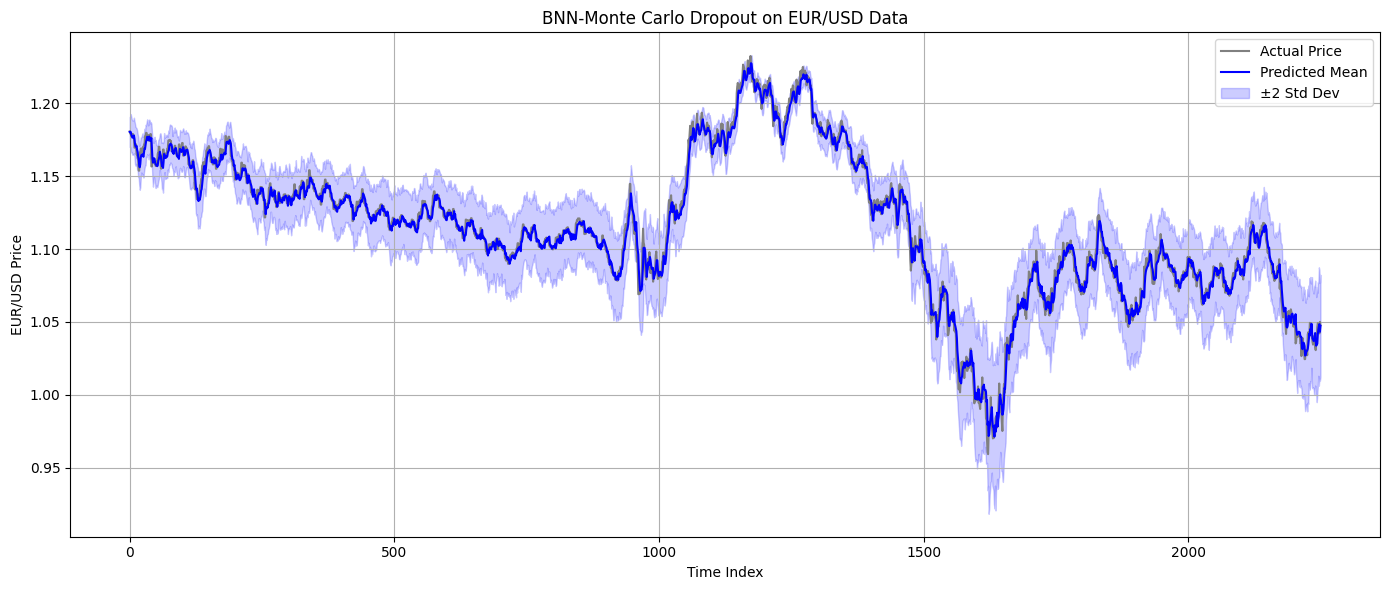

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models

# Load and preprocess the dataset
df = pd.read_csv("/kaggle/input/euro-usd-price-2001-to-2025/EUR_USD Historical Data3.csv")

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
df['Price'] = df['Price'].replace(',', '', regex=True).astype(float)

# Use time index as input
X = np.arange(len(df)).reshape(-1, 1)
y = df['Price'].values.reshape(-1, 1)

# Normalize prices
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y)

# Create sequences
def create_sequences(X, y, window_size=30):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(y[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 30
X_seq, y_seq = create_sequences(X, y_scaled, window_size)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Custom Monte Carlo Dropout layer
class MCDropout(layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

# Build the BNN model
def build_bnn_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(64, return_sequences=True),
        MCDropout(0.3),
        layers.LSTM(64),
        MCDropout(0.3),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_bnn_model((X_train.shape[1], X_train.shape[2]))
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Make MC predictions
def predict_mc(model, X, num_simulations=100):
    predictions = np.array([model.predict(X, verbose=0) for _ in range(num_simulations)])
    return predictions

mc_predictions = predict_mc(model, X_test, num_simulations=100)
mean_preds = mc_predictions.mean(axis=0).squeeze()
std_preds = mc_predictions.std(axis=0).squeeze()

# Inverse transform predictions
mean_preds_inv = scaler.inverse_transform(mean_preds.reshape(-1, 1)).squeeze()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).squeeze()
std_preds_inv = std_preds * (scaler.data_max_ - scaler.data_min_)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test_inv, mean_preds_inv))
r2 = r2_score(y_test_inv, mean_preds_inv)
print("BNN RMSE:", rmse)
print("BNN R² Score:", r2)

# Plot predictions with uncertainty
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv, label='Actual Price', color='gray')
plt.plot(mean_preds_inv, label='Predicted Mean', color='blue')
plt.fill_between(np.arange(len(mean_preds_inv)),
                 mean_preds_inv - 2*std_preds_inv,
                 mean_preds_inv + 2*std_preds_inv,
                 color='blue', alpha=0.2, label='±2 Std Dev')
plt.title('BNN-Monte Carlo Dropout on EUR/USD Data')
plt.xlabel('Time Index')
plt.ylabel('EUR/USD Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
import numpy as np
import tensorflow as tf

# Function to make Monte Carlo predictions
def predict_mc(model, X, num_simulations=100):
    predictions = np.array([model(X, training=True) for _ in range(num_simulations)])
    return predictions

# Function to calculate the Confidence Score
def calculate_confidence_score(predictions):
    # Calculate the standard deviation across the simulations
    std_preds = np.std(predictions, axis=0).squeeze()
    # The confidence score can be represented by 1 - normalized std deviation
    confidence_score = 1 - (std_preds / np.max(std_preds))  # Normalize to get a value between 0 and 1
    return confidence_score

# Assuming X_test is the test data and model is the trained BNN
# Perform Monte Carlo predictions
num_simulations = 100
mc_predictions = predict_mc(model, X_test, num_simulations=num_simulations)

# Calculate the Confidence Score
confidence_scores = calculate_confidence_score(mc_predictions)

# Print the Confidence Scores
print("Confidence Scores:", confidence_scores)


Confidence Scores: [0.77715117 0.7821271  0.78906876 ... 0.31021416 0.33558398 0.42636365]


2025-04-22 04:05:40.164141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745294740.380485      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745294740.442180      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1745294752.198314      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

Epoch 1/20


I0000 00:00:1745294755.730955      90 cuda_dnn.cc:529] Loaded cuDNN version 90300


121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0385
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9663e-04
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9446e-04
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.4791e-04
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3582e-04
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.9589e-04
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8474e-04
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5335e-04
Epoch 9/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9101e-04
Epoch 10/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5190e-04
Epoch 11/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2513e-04
Epoch 12/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2033e-04
Epoch 13/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1985e-04
Epoch 14/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9714e-04
Epoch 15/20
121/

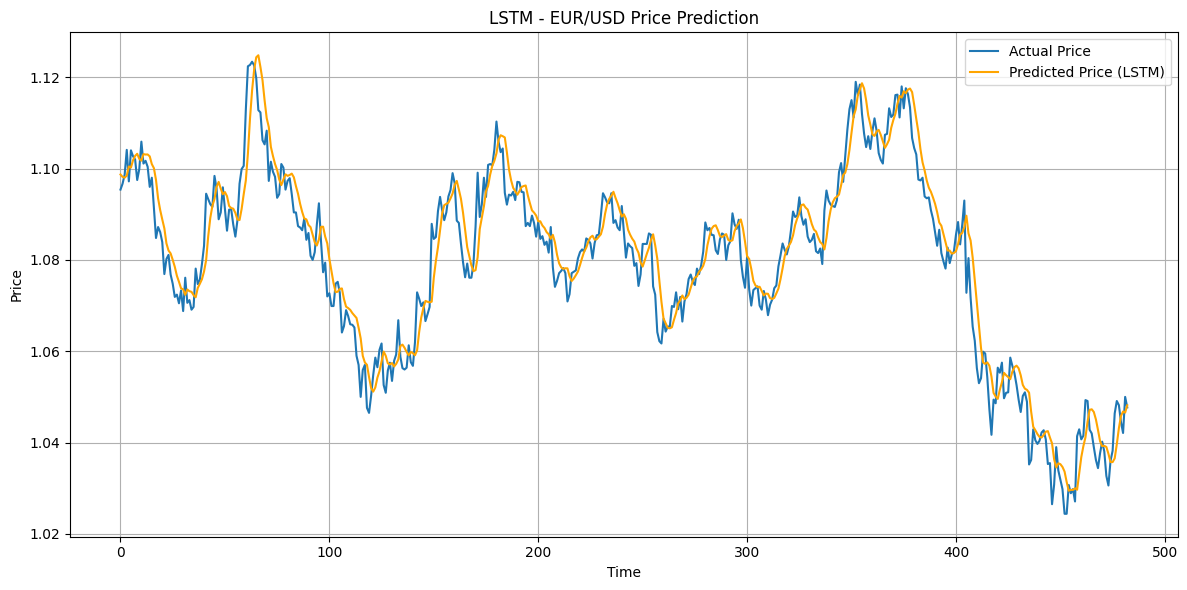

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load the dataset
df = pd.read_csv("/kaggle/input/euro-usd-price-2001-to-2025/EUR_USD Historical Data3.csv")
df = df.drop(columns=["Vol."])
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values('Date')
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

# Filter recent 5 years
df = df[df['Date'] > '2018-01-01']

# Use only 'Price'
df = df[['Date', 'Price']]
df.set_index('Date', inplace=True)

# Normalize prices
scaler = MinMaxScaler()
df['Price'] = scaler.fit_transform(df[['Price']])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_len = 30
X, y = create_sequences(df['Price'].values, seq_len)

# Train-test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(seq_len, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)

# Predict
y_pred = model.predict(X_test)

# Inverse transform
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"LSTM - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Price')
plt.plot(y_pred_inv, label='Predicted Price (LSTM)', color='orange')
plt.title('LSTM - EUR/USD Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**EDA******

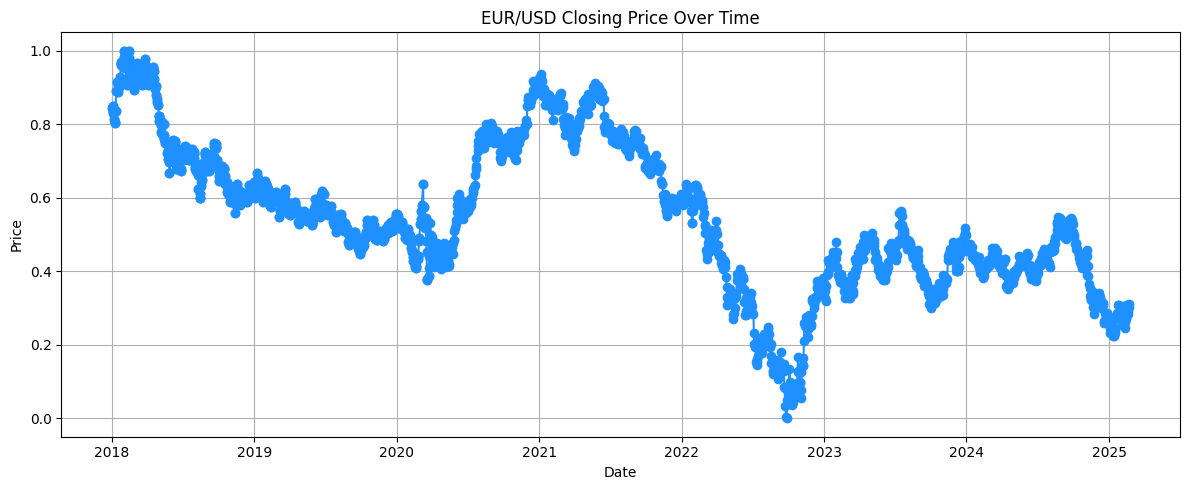

In [5]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Price'], marker='o', color='dodgerblue')
plt.title('EUR/USD Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.tight_layout()
plt.show()
